In [2]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import shap
from unidecode import unidecode

# Statistical Analysis
from scipy.stats import shapiro, stats, mannwhitneyu
#from statsmodels.api import sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, GridSearchCV,
    KFold, RandomizedSearchCV
)
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, accuracy_score,
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, auc, matthews_corrcoef, roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Other
import re
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [3]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

In [4]:
%load_ext autoreload
%autoreload 2
from help_tool import help_tool

In [5]:
stroke_data = help_tool.csv_download(
    r"C:\Users\Gintare\Desktop\Study\Module3\Sprint2\Code\archive\healthcare-dataset-stroke-data.csv").drop(columns=['Id'])

stroke_data['Age'] = stroke_data['Age'].astype(int)


# Dropping 'Gender' = 'Other'
stroke_data = stroke_data[
    (stroke_data['Age'] >= 18)
    & (stroke_data['Gender'] != 'Other')
    & (stroke_data['Work_type'] != 'Never_worked')
]

# Converting Binary answer features to 1/0
stroke_data = help_tool.dummy_columns(stroke_data, ['Gender', 'Ever_married', 'Residence_type']).drop(columns=['Gender_Male', 'Residence_type_Rural']).rename(columns={'Residence_type_Urban': 'Residence_Urban'})


# Scalling 0 to 1, as KNN is sensitive to neighbor distince
stroke_data['Age'] = stroke_data['Age']/100
stroke_data['Avg_glucose_level'] = stroke_data['Avg_glucose_level']/300
stroke_data['Bmi'] = stroke_data['Bmi']/100


# Ordinal encoding for Smoking_status
stroke_data['Smoking_status'].replace(
    {
        'Unknown': np.nan,
        'never smoked': 0,
        'formerly smoked': -1,
        'smokes': 1
    },
    inplace=True)

# Imputation with extension
stroke_data['Smoking_status_was_missing'] = stroke_data['Smoking_status'].isnull().astype(int)
stroke_data['Bmi_was_missing'] = stroke_data['Bmi'].isnull().astype(int)

In [6]:
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

In [7]:
# Removing non-scalled features
def_imputation = stroke_data_dummies.drop(['Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)


# KNNImputer for NaN values
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(def_imputation)
imputed_features = imputer.transform(def_imputation)
imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)

In [8]:
# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi']=imputed_df['Bmi']
stroke_data['Smoking_status']=imputed_df['Smoking_status'].round().astype(int)

In [9]:
stroke_data['Smoking_status'].replace(
    {
        0: 'never smoked',
        -1: 'formerly smoked',
        1: 'smokes'
    },
    inplace=True)

In [10]:
stroke_data.isna().sum()

Age                           0
Hypertension                  0
Heart_disease                 0
Work_type                     0
Avg_glucose_level             0
Bmi                           0
Smoking_status                0
Stroke                        0
Gender_Female                 0
Ever_married                  0
Residence_Urban               0
Smoking_status_was_missing    0
Bmi_was_missing               0
dtype: int64

In [11]:
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type', 'Smoking_status'])

In [12]:
help_tool.first_look(stroke_data_dummies)

Column data types:
Age                               float64
Hypertension                        int64
Heart_disease                       int64
Avg_glucose_level                 float64
Bmi                               float64
Stroke                              int64
Gender_Female                       int32
Ever_married                        int32
Residence_Urban                     int32
Smoking_status_was_missing          int32
Bmi_was_missing                     int32
Work_type_Govt_job                  int32
Work_type_Private                   int32
Work_type_Self-employed             int32
Smoking_status_formerly smoked      int32
Smoking_status_never smoked         int32
Smoking_status_smokes               int32
dtype: object

Dataset has 4248 observations and 17 features
Columns with NULL values: []
Dataset has 0 duplicates


Data is ready for modeling, no missing values or duplicates

## Splitting Data 
Splitting data into 3 subsets:
* train (training) 
* validation - model tuning vs unseen data
* test - picking out the best model, where performance is checked on unseen data

In [18]:
X = stroke_data_dummies.drop('Stroke', axis=1)
y = stroke_data_dummies['Stroke']

# Class weights
#weights = dict(zip(np.unique(y), len(y) / (len(np.unique(y)) * np.bincount(y))))

In [19]:
(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

(X_validation, X_test, y_validation, y_test) = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42, stratify=y_vt)

In [20]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [15]:
# Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [16]:
(X_train, y_train) = (X_train_resampled, y_train_resampled)

In [22]:
print(X_train_resampled.shape)
print(y_train.shape)

(4800, 16)
(2548,)


In [ ]:
threshold

# Models
## Treshold tuning

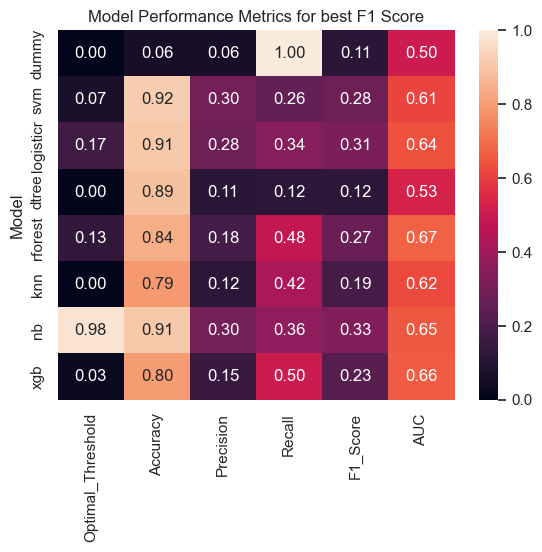

In [23]:
models = {
    'dummy': DummyClassifier(strategy='uniform', random_state=1), # Baseline model
    'svm': SVC(kernel='rbf', probability=True),
    'logisticr': LogisticRegression(max_iter=1000),
    'dtree': DecisionTreeClassifier(),
    'rforest': RandomForestClassifier(), 
    'knn': KNeighborsClassifier(), 
    'nb': GaussianNB(),  
    'xgb': XGBClassifier()
}

results = []
model_threshol_search=[]

for name, model in models.items():
    model.fit(X_train, y_train)  # assuming you have X_train and y_train defined

    y_proba = model.predict_proba(X_validation)[:, 1]  # Binary classification

    thresholds = np.linspace(0, 1, 100)

    # F1 score at each threshold
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y_validation, y_pred)
        f1_scores.append(f1)

    # Optimal threshold
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    y_pred_optimal = (y_proba > optimal_threshold).astype(int)

    results.append({'Model': name, 
                    'Optimal_Threshold': optimal_threshold, 
                    'Accuracy': accuracy_score(y_validation, y_pred_optimal), 
                    'Precision': precision_score(y_validation, y_pred_optimal), 
                    'Recall': recall_score(y_validation, y_pred_optimal), 
                    'F1_Score': f1_score(y_validation, y_pred_optimal), 
                    'AUC': roc_auc_score(y_validation, y_pred_optimal)
                    })

model_threshol_search = pd.DataFrame(results)

# Plotting the best thresholds for F1 Score
sns.heatmap(model_threshol_search.set_index('Model').round(2), annot=True, fmt=".2f")
plt.title('Model Performance Metrics for best F1 Score')
plt.show()

In [24]:
thresholds = help_tool.feature_transpose(model_threshol_search, ['Model', 'Optimal_Threshold'])
thresholds

,Model,dummy,svm,logisticr,dtree,rforest,knn,nb,xgb
1,Optimal_Threshold,0.0,0.070707,0.171717,0.0,0.131313,0.0,0.979798,0.030303


In [25]:
data = {
    'Model': ['Name', 'best_model', 'best_params'],
    'dummy': ['Dummy', np.nan, np.nan],
    'svm': ['Radial SVM', np.nan, np.nan],
    'logisticr': ['Logistic Regression', np.nan, np.nan],
    'dtree': ['Decision Tree', np.nan, np.nan],
    'rforest': ['Random Forest', np.nan, np.nan],
    'knn': ['KNN', np.nan, np.nan],
    'nb': ['Naive Bayes', np.nan, np.nan],
    'xgb': ['XGBoost', np.nan, np.nan]
}

# Create a DataFrame for the new rows
new_rows_df = pd.DataFrame(data)

# Append new rows to the original DataFrame
thresholds_df = pd.concat([thresholds, new_rows_df], ignore_index=True)

In [26]:
thresholds_df

,Model,dummy,svm,logisticr,dtree,rforest,knn,nb,xgb
0,Optimal_Threshold,0.0,0.070707,0.171717,0.0,0.131313,0.0,0.979798,0.030303
1,Name,Dummy,Radial SVM,Logistic Regression,Decision Tree,Random Forest,KNN,Naive Bayes,XGBoost
2,best_model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,best_params,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


dummy, DecisionTree and KNN have optimal threshold 0.0. This means bad?

In [30]:
models = {
    'svm': (SVC(kernel='rbf'), {'svm__C': (0.1, 100), 'svm__gamma': (0.01, 10)}),
    'logisticr': (LogisticRegression(max_iter=1000), {'logisticr__C': (0.1, 100)}),
    'dtree': (DecisionTreeClassifier(), {'dtree__max_depth': list(range(1, 11))}),
    'rforest': (RandomForestClassifier(), {'rforest__n_estimators': list(range(10, 101, 10)), 'rforest__max_depth': list(range(1, 11))}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': list(range(2, 11)), 'knn__weights': ['uniform', 'distance'],'knn__p': [1, 2]}),
    'nb': (GaussianNB(), {'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'xgb': (XGBClassifier(), {'xgb__max_depth': [3, 5, 7], 'xgb__learning_rate': [0.1, 0.01], 'xgb__n_estimators': [100, 200]})
}


for model_name, (model, param_dist) in models.items():
    my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), (model_name, model)])

    random_search = RandomizedSearchCV(
        estimator=my_pipeline, param_distributions=param_dist, cv=5, scoring='f1', n_iter=min(10, len(param_dist)), n_jobs=-1, random_state=42)

    random_search.fit(X_train_resampled, y_train_resampled)

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    #best_model.threshold = thresholds_df[model_name].iloc[0]

    if model_name == 'svm': 
        svm=best_model
        svm_param=best_params
    elif model_name == 'logisticr': 
        logisticr=best_model
        logisticr_param=best_params
    elif model_name == 'dtree': 
        dtree=best_model
        dtree_param=best_params
    elif model_name == 'rforest': 
        rforest=best_model
        rforest_param=best_params
    elif model_name == 'knn': 
        knn=best_model
        knn_param=best_params
    elif model_name == 'nb': 
        nb=best_model
        nb_param=best_params
    elif model_name == 'xgb': 
        xgb=best_model
        xgb_param=best_params

    print(f'--- Best Parameters for {model_name}')         
    help_tool.model_selection_f1(best_model, X_train_resampled, y_train_resampled, X_validation, y_validation)

--- Best Parameters for svm
Train F1: 100.00%
Validation F1: 4.55%
ROC AUC: 0.67
--- Best Parameters for logisticr
Train F1: 78.40%
Validation F1: 24.55%
ROC AUC: 0.81
--- Best Parameters for dtree
Train F1: 88.55%
Validation F1: 19.79%
ROC AUC: 0.71
--- Best Parameters for rforest
Train F1: 91.77%
Validation F1: 21.00%
ROC AUC: 0.79
--- Best Parameters for knn
Train F1: 100.00%
Validation F1: 16.29%
ROC AUC: 0.66
--- Best Parameters for nb
Train F1: 72.99%
Validation F1: 26.20%
ROC AUC: 0.80
--- Best Parameters for xgb
Train F1: 89.08%
Validation F1: 19.48%
ROC AUC: 0.75


In [28]:
models = {
    'svm': (SVC(kernel='rbf'), {'svm__C': (0.1, 100), 'svm__gamma': (0.01, 10)}),
    'logisticr': (LogisticRegression(max_iter=1000), {'logisticr__C': (0.1, 100)}),
    'dtree': (DecisionTreeClassifier(), {'dtree__max_depth': list(range(1, 11))}),
    'rforest': (RandomForestClassifier(), {'rforest__n_estimators': list(range(10, 101, 10)), 'rforest__max_depth': list(range(1, 11))}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': list(range(2, 11)), 'knn__weights': ['uniform', 'distance'],'knn__p': [1, 2]}),
    'nb': (GaussianNB(), {'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'xgb': (XGBClassifier(), {'xgb__max_depth': [3, 5, 7], 'xgb__learning_rate': [0.1, 0.01], 'xgb__n_estimators': [100, 200]})
}


for model_name, (model, param_dist) in models.items():
    my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), (model_name, model)])

    random_search = RandomizedSearchCV(
        estimator=my_pipeline, param_distributions=param_dist, cv=5, scoring='f1', n_iter=min(10, len(param_dist)), n_jobs=-1, random_state=42)

    random_search.fit(X_train_resampled, y_train_resampled)

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    best_model.threshold = thresholds_df[model_name].iloc[0]

    if model_name == 'svm': 
        svm=best_model
        svm_param=best_params
    elif model_name == 'logisticr': 
        logisticr=best_model
        logisticr_param=best_params
    elif model_name == 'dtree': 
        dtree=best_model
        dtree_param=best_params
    elif model_name == 'rforest': 
        rforest=best_model
        rforest_param=best_params
    elif model_name == 'knn': 
        knn=best_model
        knn_param=best_params
    elif model_name == 'nb': 
        nb=best_model
        nb_param=best_params
    elif model_name == 'xgb': 
        xgb=best_model
        xgb_param=best_params

    print(f'--- Best Parameters for {model_name}')         
    help_tool.model_selection_f1(best_model, X_train_resampled, y_train_resampled, X_validation, y_validation)

--- Best Parameters for svm
Train F1: 100.00%
Validation F1: 4.55%
ROC AUC: 0.67
--- Best Parameters for logisticr
Train F1: 78.40%
Validation F1: 24.55%
ROC AUC: 0.81
--- Best Parameters for dtree
Train F1: 88.55%
Validation F1: 19.72%
ROC AUC: 0.70
--- Best Parameters for rforest
Train F1: 91.76%
Validation F1: 24.89%
ROC AUC: 0.79
--- Best Parameters for knn
Train F1: 100.00%
Validation F1: 16.29%
ROC AUC: 0.66
--- Best Parameters for nb
Train F1: 72.99%
Validation F1: 26.20%
ROC AUC: 0.80
--- Best Parameters for xgb
Train F1: 89.08%
Validation F1: 19.48%
ROC AUC: 0.75


### Hyperparameter tuning

In [29]:
# Define the models and their respective hyperparameter grids
models = {
    'svm': (SVC(kernel='rbf', probability=True), {'C': (0.1, 100), 'gamma': (0.01, 10)}),
    'logisticr': (LogisticRegression(max_iter=1000), {'C': (0.1, 100)}),
    'dtree': (DecisionTreeClassifier(), {'max_depth': list(range(1, 11))}),
    'rforest': (RandomForestClassifier(), {'n_estimators': list(range(10, 101, 10)), 'max_depth': list(range(1, 11))}),
    'knn': (KNeighborsClassifier(), {'n_neighbors': list(range(2, 11)), 'weights': ['uniform', 'distance'], 'p': [1, 2]}),
    'nb': (GaussianNB(), {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'xgb': (XGBClassifier(), {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200]})
}


# Suppress user warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

for model_name, (model, param_grid) in models.items():
    # Perform random search for the current model
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=5, random_state=42)
    random_search.fit(X_train, y_train)


    # Get the best hyperparameters
    best_params = random_search.best_params_

    # Train a new model with the best hyperparameters
    best_model = model.__class__(**best_params)
    best_model.fit(X_train, y_train)

    # Calculate predictions
    if hasattr(best_model, "predict_proba"):
        predictions = best_model.predict_proba(X_validation)[:, 1]
    else:
        predictions = best_model.decision_function(X_validation)

    # Adjust decision threshold using the optimal threshold
    optimal_threshold = thresholds_df[model_name].iloc[0]
    adjusted_predictions = (predictions > optimal_threshold).astype(int)


    # thresholds[model_name][2]=best_model
    # thresholds[model_name][3]=best_params


    if model_name == 'svm': 
        svm=best_model
        svm_param=best_params
    elif model_name == 'logisticr': 
        logisticr=best_model
        logisticr_param=best_params
    elif model_name == 'dtree': 
        dtree=best_model
        dtree_param=best_params
    elif model_name == 'rforest': 
        rforest=best_model
        rforest_param=best_params
    elif model_name == 'knn': 
        knn=best_model
        knn_param=best_params
    elif model_name == 'nb': 
        nb=best_model
        nb_param=best_params
    elif model_name == 'xgb': 
        xgb=best_model
        xgb_param=best_params

    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_params}")
    print(f"Adjusted F1 Score: {f1_score(y_validation, adjusted_predictions):.2f}") # Evaluate F1 score with the adjusted threshold

# # Restore user warnings
# warnings.resetwarnings()

Model: svm
Best Hyperparameters: {'gamma': 10, 'C': 100}
Adjusted F1 Score: 0.05
Model: logisticr
Best Hyperparameters: {'C': 100}
Adjusted F1 Score: 0.30
Model: dtree
Best Hyperparameters: {'max_depth': 9}
Adjusted F1 Score: 0.17
Model: rforest
Best Hyperparameters: {'n_estimators': 10, 'max_depth': 8}
Adjusted F1 Score: 0.29
Model: knn
Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 6}
Adjusted F1 Score: 0.18
Model: nb
Best Hyperparameters: {'var_smoothing': 1e-09}
Adjusted F1 Score: 0.33
Model: xgb
Best Hyperparameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
Adjusted F1 Score: 0.23


## ROC on TEST data (3rd partintion)
Threshold was optimized on validation data, so ROC curves would show perfect 1 for validation. Unless using Test?

In [33]:
models = [svm, logisticr, dtree, rforest, knn, nb, xgb]
model_name = ['svm', 'logisticr', 'dtree', 'rforest', 'knn', 'nb', 'xgb']

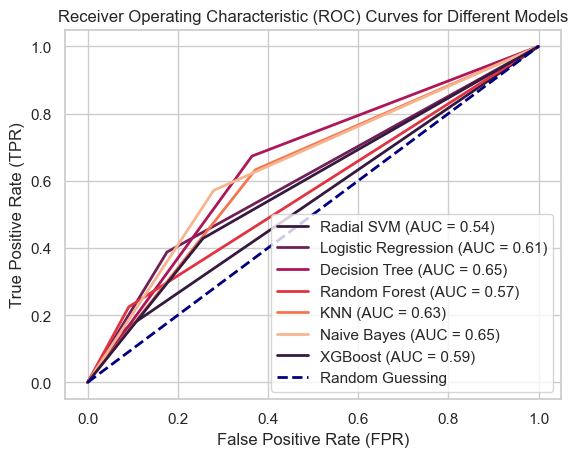

In [39]:
for model, label in zip(models, model_name):
    """ ROC Curve plot"""
    if hasattr(model, 'decision_function'):
        predictions = model.decision_function(X_test)
    else:
        predictions = model.predict_proba(X_test)[:, 1]

    # Adjust decision threshold using the optimal threshold
    optimal_threshold = thresholds_df[label].iloc[0]
    adjusted_predictions = (predictions > optimal_threshold).astype(int)

    fpr, tpr, thresholds = roc_curve(y_test, adjusted_predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{thresholds_df[label].iloc[1]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Models')
plt.legend(loc='lower right')
plt.show()

In [40]:
# models = [svm, logisticr, dtree, rforest, knn, nb, xgb]
# labels = ['Radial SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes', 'XGBoost']

# help_tool.plot_roc_curve_many(models, labels, X_validation, y_validation)

## Cross Validation
Cross Validation is performed on all non-tuned models. Weights are used for Validation data.

In [67]:
classifiers = {
    'svm': SVC(kernel='rbf', probability=True, C=svm_param['C'], gamma=svm_param['gamma']),
    'logisticr': LogisticRegression(C=logisticr_param['C']), 
    'dtree': DecisionTreeClassifier(max_depth=dtree_param['max_depth']), 
    'rforest': RandomForestClassifier(n_estimators=rforest_param['n_estimators'], max_depth=rforest_param['max_depth']),
    'knn': KNeighborsClassifier(weights=knn_param['weights'], p=knn_param['p'], n_neighbors=knn_param['n_neighbors']),
    'nb': GaussianNB(var_smoothing=nb_param['var_smoothing']),
    'xgb': XGBClassifier(max_depth=xgb_param['max_depth'], learning_rate=xgb_param['learning_rate'], n_estimators=xgb_param['n_estimators'])
}

# Initialize KFold cross-validator
kf = KFold(n_splits=10)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
# Initialize lists to store metric scores
metric_scores = {metric: {clf_name: [] for clf_name in classifiers.keys()} for metric in ['accuracy', 'precision', 'recall']}

def corss(metric):
    # Loop over each fold
    for train_index, val_index in kf.split(X_train):
        X_train_i, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_i, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        cv_results = []
        # Loop over each classifier
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_i, y_train_i)

        
            # Predict probabilities/scores on validation set
            scores = clf.predict_proba(X_val)[:, 1]  # Assuming binary classification
            
            # Get optimal threshold from model_threshol_search DataFrame
            threshold = model_threshol_search[model_threshol_search['Model'] == clf_name]['Optimal_Threshold'].iloc[0]
            
            # Apply threshold
            y_pred = scores > threshold
            
            # Calculate metrics
            metric_scores['accuracy'][clf_name].append(accuracy_score(y_val, y_pred))
            metric_scores['precision'][clf_name].append(precision_score(y_val, y_pred))
            metric_scores['recall'][clf_name].append(recall_score(y_val, y_pred))

    # Calculate average scores
    avg_metric_scores = {metric: {clf_name: np.mean(scores) for clf_name, scores in clf_scores.items()} for metric, clf_scores in metric_scores.items()}
    
    for clf_name, scores in avg_metric_scores['accuracy'].items():
        cv_results.append({
            'Classifier': classifiers[clf_name].__class__.__name__,
            'CV Mean Accuracy': np.mean(scores),
            'CV Mean Precision': np.mean(avg_metric_scores['precision'][clf_name]),
            'CV Mean Recall': np.mean(avg_metric_scores['recall'][clf_name]),
            'Accuracy': scores,
            'Precision': avg_metric_scores['precision'][clf_name],
            'Recall': avg_metric_scores['recall'][clf_name]
        })

    model_info = pd.DataFrame(cv_results)
    return model_info


model_info = corss('Precision')


In [69]:
model_info

,Classifier,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,Std Accuracy,Accuracy,Precision,Recall
0,SVC,0.896458,0.634109,0.796884,0.0,0.896458,0.634109,0.796884
1,LogisticRegression,0.734375,0.579223,0.670073,0.0,0.734375,0.579223,0.670073
2,DecisionTreeClassifier,0.812083,0.557708,0.911165,0.0,0.812083,0.557708,0.911165
3,RandomForestClassifier,0.841667,0.620981,0.732570,0.0,0.841667,0.620981,0.732570
4,KNeighborsClassifier,0.799583,0.552337,0.983587,0.0,0.799583,0.552337,0.983587
5,GaussianNB,0.707708,0.553049,0.709400,0.0,0.707708,0.553049,0.709400
6,XGBClassifier,0.868750,0.582373,0.956534,0.0,0.868750,0.582373,0.956534


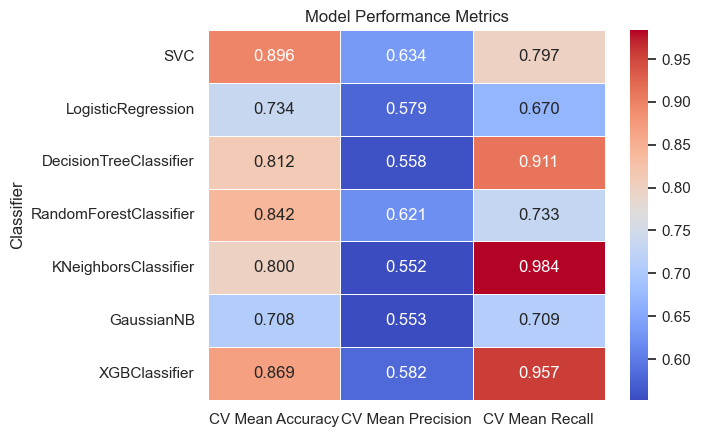

In [77]:
# Parameter heatmap
heatmap_data = model_info[['Classifier', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall']]

heatmap_data.set_index('Classifier', inplace=True)

sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.title('Model Performance Metrics')
plt.show()

In [78]:
# classifiers = [
#     SVC(kernel='rbf', C= svm_param['C'], gamma= svm_param['gamma']), 
#     LogisticRegression(C= logisticr_param['C']), 
#     DecisionTreeClassifier(max_depth= dtree_param['max_depth']), 
#     RandomForestClassifier(n_estimators= rforest_param['n_estimators'], max_depth= rforest_param['max_depth']), 
#     KNeighborsClassifier(weights= knn_param['weights'], p= knn_param['p'], n_neighbors= knn_param['n_neighbors']),
#     GaussianNB(var_smoothing= nb_param['var_smoothing']),
#     XGBClassifier(max_depth=xgb_param['max_depth'], learning_rate=xgb_param['learning_rate'], n_estimators=xgb_param['n_estimators'])
# ]

# #warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# help_tool.cross_validation_plots(classifiers, 10, X, y, 'Precision')

In [83]:
classifier_names = [
    'Radial SVM', 'Logistic Regression',
    'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes'
]
classifiers = {
    'svm': SVC(kernel='rbf', probability=True, C=svm_param['C'], gamma=svm_param['gamma']),
    'logisticr': LogisticRegression(C=logisticr_param['C']), 
    'dtree': DecisionTreeClassifier(max_depth=dtree_param['max_depth']), 
    'rforest': RandomForestClassifier(n_estimators=rforest_param['n_estimators'], max_depth=rforest_param['max_depth']),
    'knn': KNeighborsClassifier(weights=knn_param['weights'], p=knn_param['p'], n_neighbors=knn_param['n_neighbors']),
    'nb': GaussianNB(var_smoothing=nb_param['var_smoothing']),
    'xgb': XGBClassifier(max_depth=xgb_param['max_depth'], learning_rate=xgb_param['learning_rate'], n_estimators=xgb_param['n_estimators'])
}


In [93]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def corss(metric):
    # Initialize lists to store metric scores and confusion matrices
    metric_scores = {metric: {clf_name: [] for clf_name in classifiers.keys()} for metric in ['accuracy', 'precision', 'recall']}
    confusion_matrices = {clf_name: [] for clf_name in classifiers.keys()}
    
    # Loop over each fold
    for train_index, val_index in kf.split(X_train):
        X_train_i, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_i, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Loop over each classifier
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_i, y_train_i)

            # Predict probabilities/scores on validation set
            scores = clf.predict_proba(X_val)[:, 1]  # Assuming binary classification
            
            # Get optimal threshold from model_threshol_search DataFrame
            threshold = model_threshol_search[model_threshol_search['Model'] == clf_name]['Optimal_Threshold'].iloc[0]
            
            # Apply threshold
            y_pred = scores > threshold
            
            # Calculate metrics
            metric_scores['accuracy'][clf_name].append(accuracy_score(y_val, y_pred))
            metric_scores['precision'][clf_name].append(precision_score(y_val, y_pred))
            metric_scores['recall'][clf_name].append(recall_score(y_val, y_pred))
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_val, y_pred)
            
            # Ensure all confusion matrices have the same shape
            if cm.shape != (2, 2):
                cm = np.pad(cm, ((0, 2 - cm.shape[0]), (0, 2 - cm.shape[1])), mode='constant')
            
            confusion_matrices[clf_name].append(cm)

    # Calculate average scores
    avg_metric_scores = {metric: {clf_name: np.mean(scores) for clf_name, scores in clf_scores.items()} for metric, clf_scores in metric_scores.items()}
    
    # Calculate average confusion matrix
    avg_confusion_matrices = {clf_name: np.mean(cm_list, axis=0) for clf_name, cm_list in confusion_matrices.items()}
    
    # Convert average confusion matrices to DataFrame
    cm_data = [{'Classifier': clf_name, 'Average Confusion Matrix': cm} for clf_name, cm in avg_confusion_matrices.items()]
    confusion_matrix_df = pd.DataFrame(cm_data)

    return avg_metric_scores, confusion_matrix_df


avg_metric_scores, confusion_matrix_df = corss('Precision')
print("Average Metric Scores:")
print(avg_metric_scores)

print("\nAverage Confusion Matrices:")
print(confusion_matrix_df)


Average Metric Scores:
{'accuracy': {'svm': 0.8970833333333333, 'logisticr': 0.734375, 'dtree': 0.8127083333333334, 'rforest': 0.8383333333333333, 'knn': 0.7995833333333333, 'nb': 0.7077083333333334, 'xgb': 0.86875}, 'precision': {'svm': 0.6344605695225789, 'logisticr': 0.5792225227315353, 'dtree': 0.5561132863400564, 'rforest': 0.6202160474063511, 'knn': 0.552337292309966, 'nb': 0.5530485288898392, 'xgb': 0.5823727219665064}, 'recall': {'svm': 0.7973835446455961, 'logisticr': 0.6700734824054669, 'dtree': 0.9013603847184951, 'rforest': 0.7356058262638137, 'knn': 0.9835866599387006, 'nb': 0.7094003104273161, 'xgb': 0.9565338634506475}}

Average Confusion Matrices:
  Classifier        Average Confusion Matrix
0        svm  [[214.2, 25.8], [23.6, 216.4]]
1  logisticr  [[193.6, 46.4], [81.1, 158.9]]
2      dtree  [[160.4, 79.6], [10.3, 229.7]]
3    rforest  [[210.9, 29.1], [48.5, 191.5]]
4        knn   [[192.9, 95.1], [1.1, 190.9]]
5         nb  [[171.6, 68.4], [71.9, 168.1]]
6        xgb 

In [94]:
avg_metric_scores

{'accuracy': {'svm': 0.8970833333333333,
  'logisticr': 0.734375,
  'dtree': 0.8127083333333334,
  'rforest': 0.8383333333333333,
  'knn': 0.7995833333333333,
  'nb': 0.7077083333333334,
  'xgb': 0.86875},
 'precision': {'svm': 0.6344605695225789,
  'logisticr': 0.5792225227315353,
  'dtree': 0.5561132863400564,
  'rforest': 0.6202160474063511,
  'knn': 0.552337292309966,
  'nb': 0.5530485288898392,
  'xgb': 0.5823727219665064},
 'recall': {'svm': 0.7973835446455961,
  'logisticr': 0.6700734824054669,
  'dtree': 0.9013603847184951,
  'rforest': 0.7356058262638137,
  'knn': 0.9835866599387006,
  'nb': 0.7094003104273161,
  'xgb': 0.9565338634506475}}

In [97]:
confusion_matrix_df

,Classifier,Average Confusion Matrix
0,svm,"[[214.2, 25.8], [23.6, 216.4]]"
1,logisticr,"[[193.6, 46.4], [81.1, 158.9]]"
2,dtree,"[[160.4, 79.6], [10.3, 229.7]]"
3,rforest,"[[210.9, 29.1], [48.5, 191.5]]"
4,knn,"[[192.9, 95.1], [1.1, 190.9]]"
5,nb,"[[171.6, 68.4], [71.9, 168.1]]"
6,xgb,"[[227.5, 60.5], [2.5, 189.5]]"


In [95]:
confusion_matrix_df[confusion_matrix_df['Classifier'] == 'svm']

,Classifier,Average Confusion Matrix
0,svm,"[[214.2, 25.8], [23.6, 216.4]]"


In [100]:
confusion_matrix_df

,Average Confusion Matrix
Classifier,
svm,"[[214.2, 25.8], [23.6, 216.4]]"
logisticr,"[[193.6, 46.4], [81.1, 158.9]]"
dtree,"[[160.4, 79.6], [10.3, 229.7]]"
rforest,"[[210.9, 29.1], [48.5, 191.5]]"
knn,"[[192.9, 95.1], [1.1, 190.9]]"
nb,"[[171.6, 68.4], [71.9, 168.1]]"
xgb,"[[227.5, 60.5], [2.5, 189.5]]"


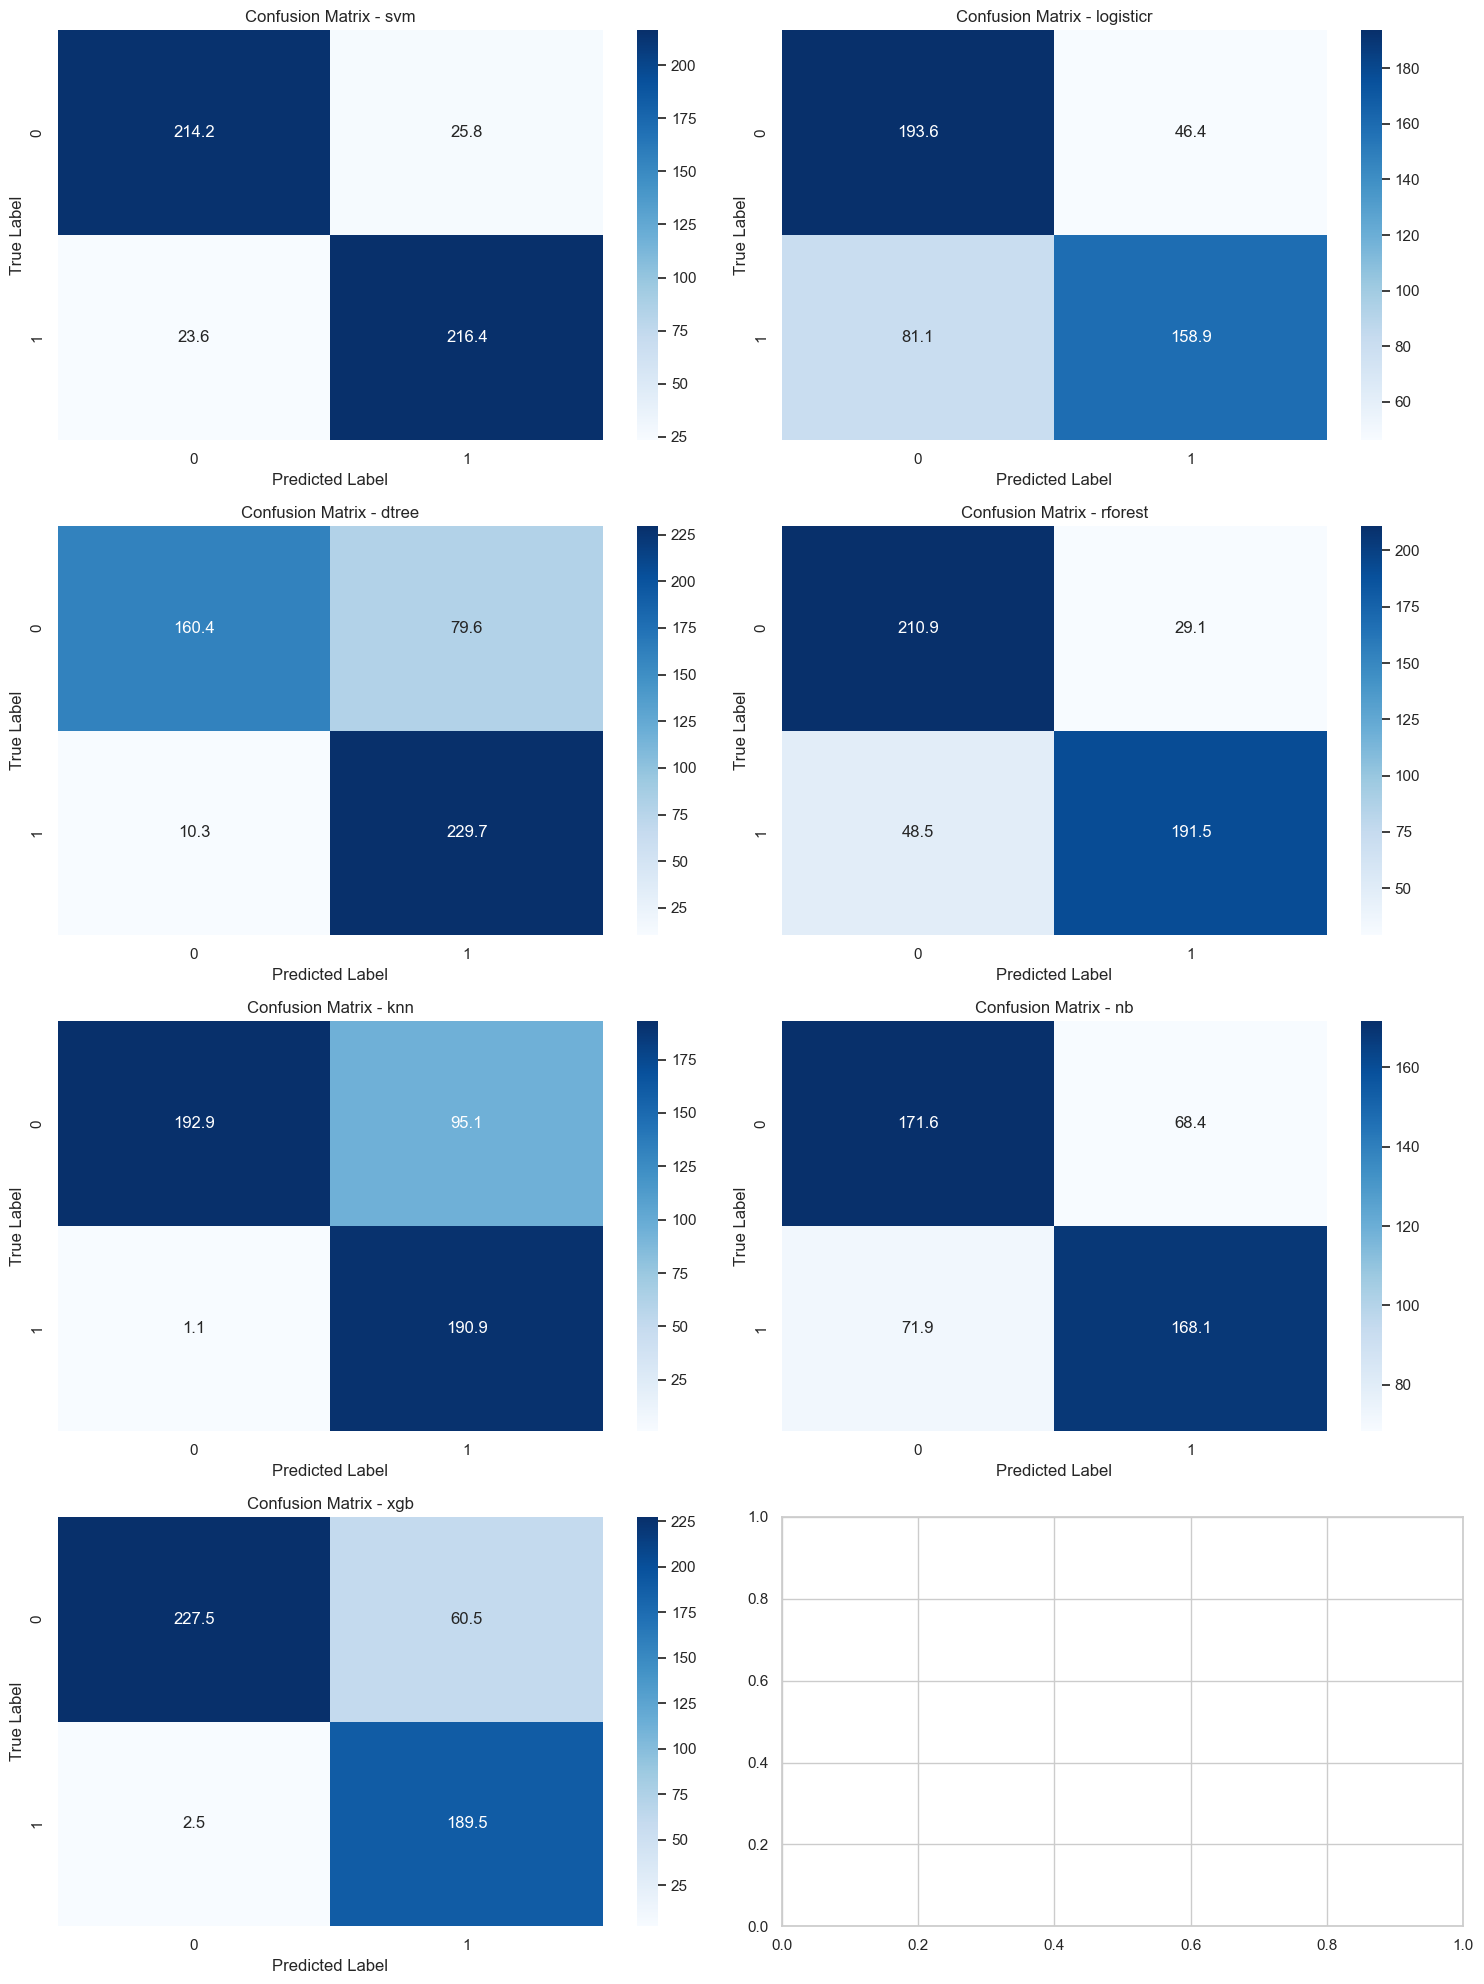

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the index of the DataFrame to 'Classifier' column
#confusion_matrix_df.set_index('Classifier', inplace=True)

# Get the number of classifiers
num_classifiers = len(confusion_matrix_df)

# Calculate the number of rows and columns for the subplot grid
num_rows = int(np.ceil(num_classifiers / 2))
num_cols = min(2, num_classifiers)

# Create a new figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes if necessary
axes = axes.flatten()

# Loop over each classifier and plot its confusion matrix
for i, (classifier, cm) in enumerate(confusion_matrix_df.iterrows()):
    sns.heatmap(cm['Average Confusion Matrix'], annot=True, cmap='Blues', fmt='g', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {classifier}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


KeyError: 'Confusion Matrix'

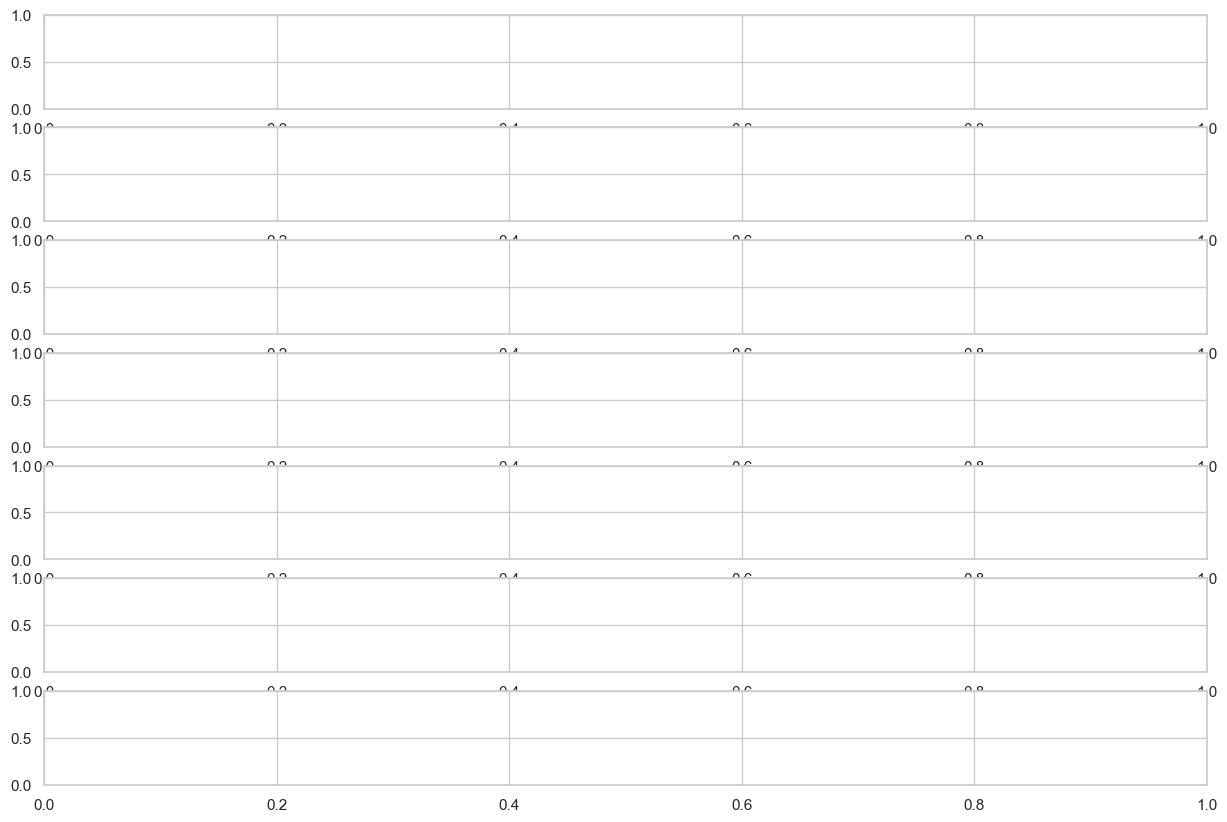

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot grid
num_rows = len(classifiers)
num_cols = len(confusion_matrix_df) // num_rows

# Create a new figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes if necessary
axes = axes.flatten()

# Loop over each classifier and confusion matrix
for i, (clf_name, cm) in enumerate(zip(confusion_matrix_df['Classifier'], confusion_matrix_df['Confusion Matrix'])):
    # Extract row and column indices for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Plot confusion matrix as heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[i])
    
    # Set title and labels
    axes[i].set_title(f'Confusion Matrix - {clf_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


TypeError: Cannot clone object ''svm'' (type <class 'str'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

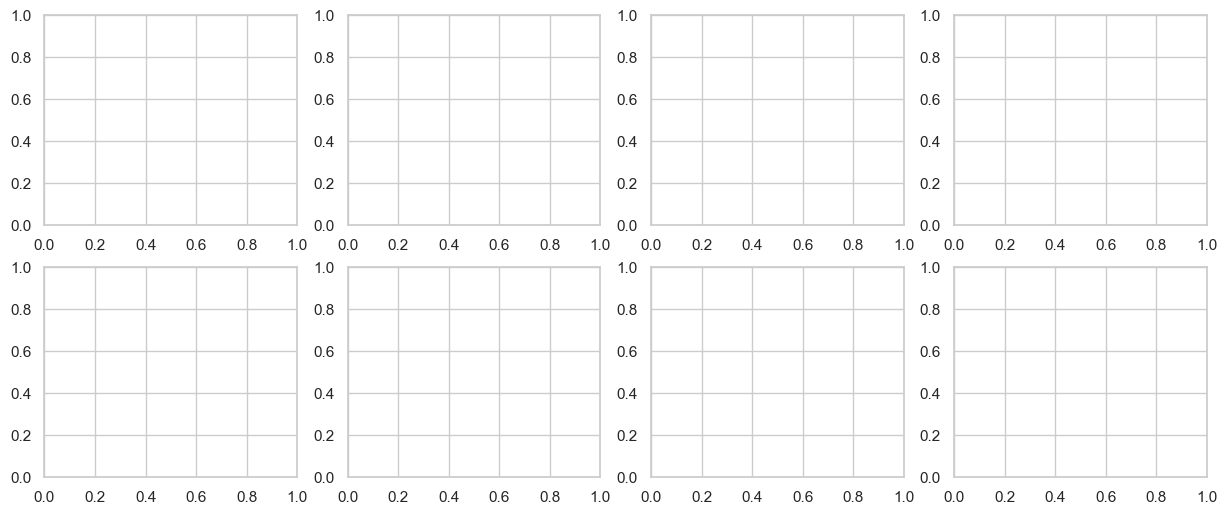

In [82]:
""" Cross Validation Matrix """
f, ax = plt.subplots(2, 4, figsize=(15, 6))
ax = ax.flatten()

# Iterate through classifiers and plot confusion matrices
for i, (classifier, classifier_name) in enumerate(zip(classifiers, classifier_names)):
    y_pred = cross_val_predict(classifier, X_train, y_train, cv=10)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, ax=ax[i], annot=True, fmt='2.0f')
    ax[i].set_title(f'Matrix for {classifier_name}')
    ax[i].set_xlabel('Predicted Label')
    ax[i].set_ylabel('True Label')


plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

TypeError: Cannot clone object ''svm'' (type <class 'str'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

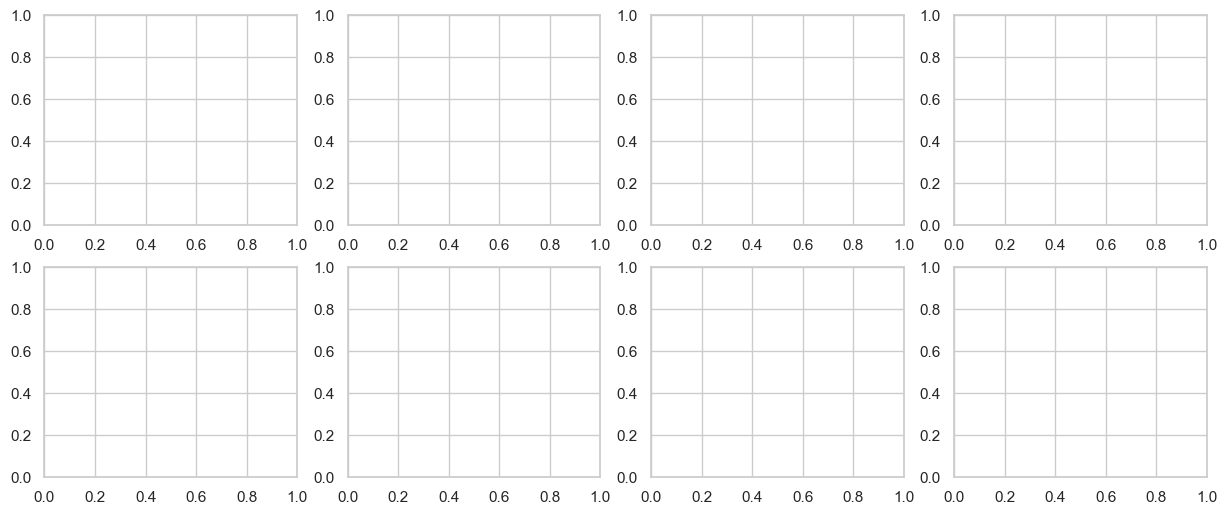

In [80]:
classifier_names = [
    'Radial SVM', 'Logistic Regression',
    'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes'
]

help_tool.cross_validation_matrix(classifiers, classifier_names, X_train, y_train)

## Oversampling

In [18]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [1]:
y_train_resampled.value_counts()

NameError: name 'y_train_resampled' is not defined

In [42]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train_resampled, y_train_resampled)

help_tool.model_selection_recall(dummy, X_train_resampled, y_train_resampled, X_validation, y_validation)

Train Recall: 50.68%
Validation Recall: 9.13%
ROC AUC: 0.50


In [39]:
models = {
    'svm': (SVC(kernel='rbf'), {'svm__C': (0.1, 100), 'svm__gamma': (0.01, 10)}),
    'logisticr': (LogisticRegression(max_iter=1000), {'logisticr__C': (0.1, 100)}),
    'dtree': (DecisionTreeClassifier(), {'dtree__max_depth': list(range(1, 11))}),
    'rforest': (RandomForestClassifier(), {'rforest__n_estimators': list(range(10, 101, 10)), 'rforest__max_depth': list(range(1, 11))}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': list(range(2, 11)), 'knn__weights': ['uniform', 'distance'],'knn__p': [1, 2]}),
    'nb': (GaussianNB(), {'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'xgb': (XGBClassifier(), {'xgb__max_depth': [3, 5, 7], 'xgb__learning_rate': [0.1, 0.01], 'xgb__n_estimators': [100, 200]})
}


for model_name, (model, param_dist) in models.items():
    my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), (model_name, model)])

    random_search = RandomizedSearchCV(
        estimator=my_pipeline, param_distributions=param_dist, cv=5, scoring='f1', n_iter=min(10, len(param_dist)), n_jobs=-1, random_state=42)

    random_search.fit(X_train_resampled, y_train_resampled)

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    if model_name == 'svm': 
        svm=best_model
        svm_param=best_params
    elif model_name == 'logisticr': 
        logisticr=best_model
        logisticr_param=best_params
    elif model_name == 'dtree': 
        dtree=best_model
        dtree_param=best_params
    elif model_name == 'rforest': 
        rforest=best_model
        rforest_param=best_params
    elif model_name == 'knn': 
        knn=best_model
        knn_param=best_params
    elif model_name == 'nb': 
        nb=best_model
        nb_param=best_params
    elif model_name == 'xgb': 
        xgb=best_model
        xgb_param=best_params

    print(f'--- Best Parameters for {model_name}')         
    help_tool.model_selection_recall(best_model, X_train_resampled, y_train_resampled, X_validation, y_validation)

--- Best Parameters for svm
Train Recall: 97.21%
Validation Recall: 11.36%
ROC AUC: 0.61
--- Best Parameters for logisticr
Train Recall: 77.08%
Validation Recall: 24.12%
ROC AUC: 0.80
--- Best Parameters for dtree
Train Recall: 87.91%
Validation Recall: 17.80%
ROC AUC: 0.65
--- Best Parameters for rforest
Train Recall: 91.80%
Validation Recall: 20.97%
ROC AUC: 0.75
--- Best Parameters for knn
Train Recall: 100.00%
Validation Recall: 13.33%
ROC AUC: 0.60
--- Best Parameters for nb
Train Recall: 70.57%
Validation Recall: 25.90%
ROC AUC: 0.81
--- Best Parameters for xgb
Train Recall: 89.02%
Validation Recall: 21.77%
ROC AUC: 0.72


In [137]:
models = [svm, logisticr, dtree, rforest, knn, nb, xgb]
labels = ['Radial SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes', 'XGBoost']

In [ ]:
for model, label in zip(models, labels):
    """ ROC Curve plot"""
    if hasattr(model, 'decision_function'):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_train, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Models')
plt.legend(loc='lower right')
plt.show()

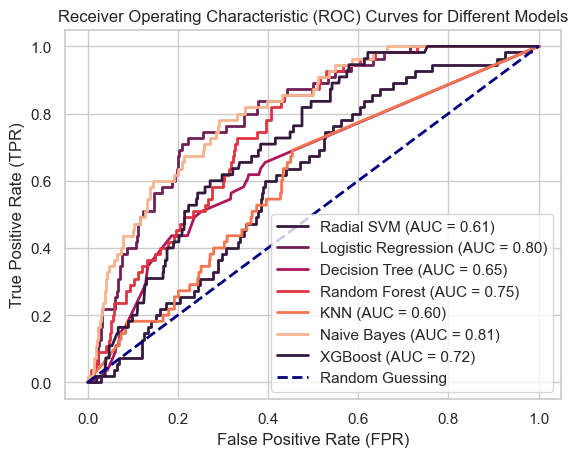

In [43]:
models = [svm, logisticr, dtree, rforest, knn, nb, xgb]
labels = ['Radial SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes', 'XGBoost']

help_tool.plot_roc_curve_many(models, labels, X_validation, y_validation)

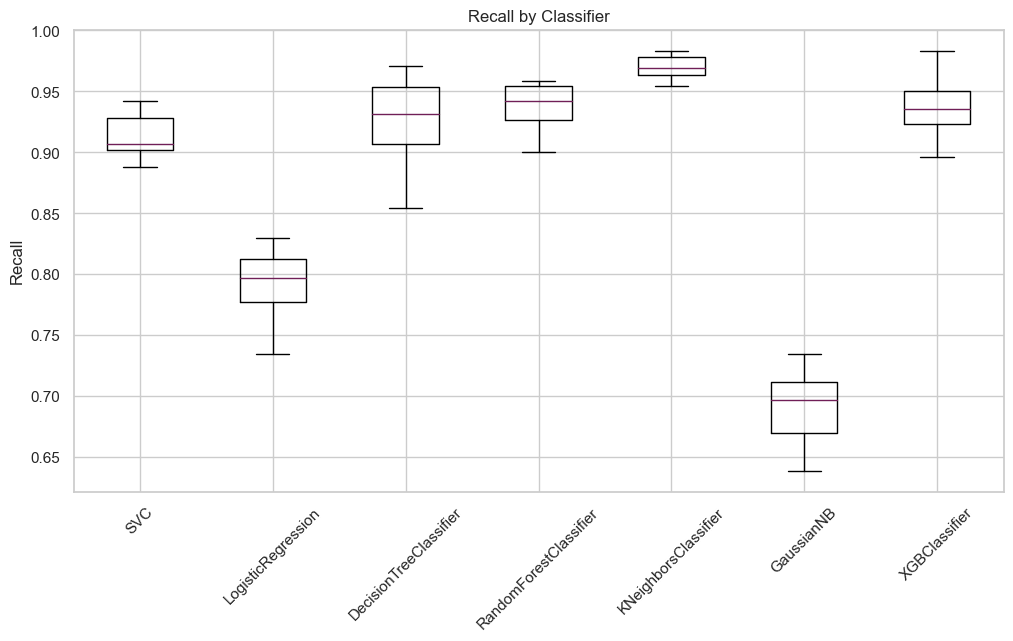

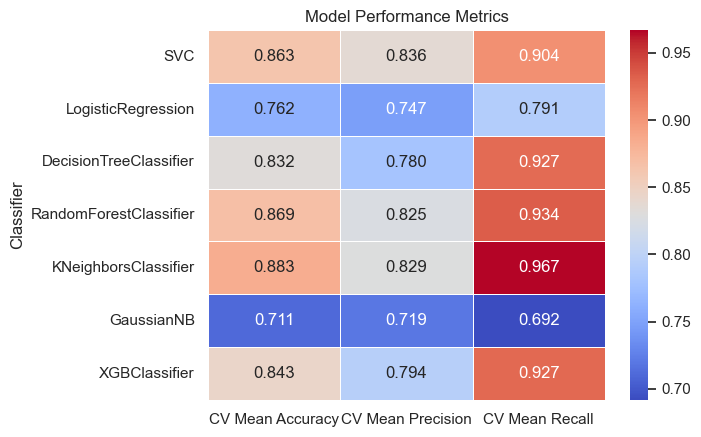

In [23]:
classifiers = [
    SVC(kernel='rbf', C= svm_param['svm__C'], gamma= svm_param['svm__gamma']), 
    LogisticRegression(C= logisticr_param['logisticr__C']), 
    DecisionTreeClassifier(max_depth= dtree_param['dtree__max_depth']), 
    RandomForestClassifier(n_estimators= rforest_param['rforest__n_estimators'], max_depth= rforest_param['rforest__max_depth']), 
    KNeighborsClassifier(weights= knn_param['knn__weights'], p= knn_param['knn__p'], n_neighbors= knn_param['knn__n_neighbors']),
    GaussianNB(var_smoothing= nb_param['nb__var_smoothing']),
    XGBClassifier(max_depth=xgb_param['xgb__max_depth'], learning_rate=xgb_param['xgb__learning_rate'], n_estimators=xgb_param['xgb__n_estimators'])
]


help_tool.cross_validation_plots(classifiers, 10, X_train_resampled, y_train_resampled, 'Recall')

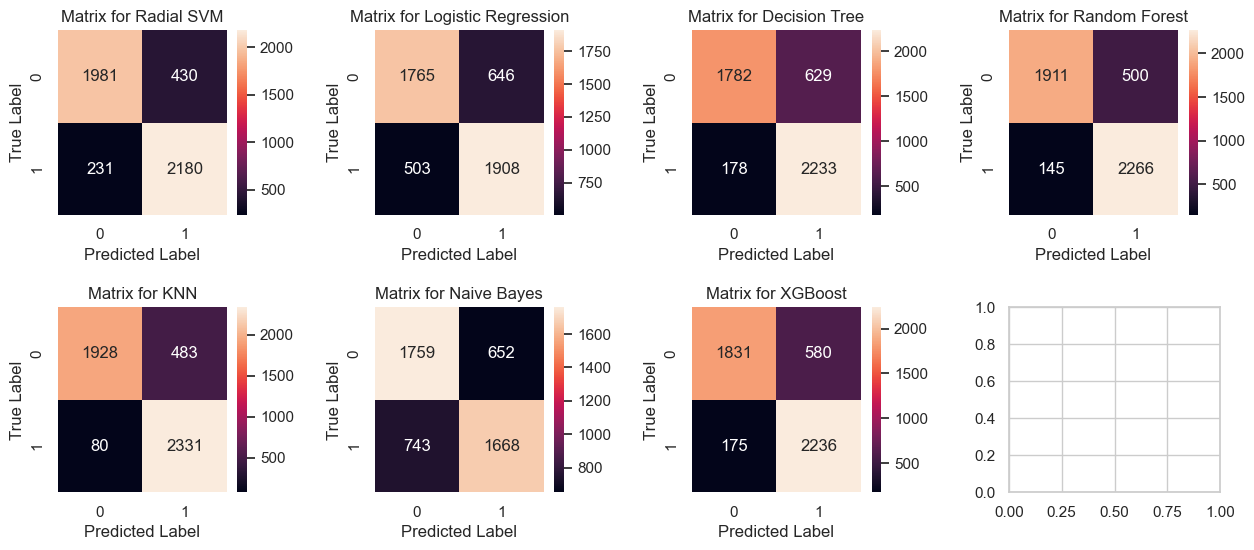

In [24]:
classifier_names = [
    'Radial SVM', 'Logistic Regression',
    'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes', 'XGBoost'
]

help_tool.cross_validation_matrix(classifiers, classifier_names, X_train_resampled, y_train_resampled)

In [25]:
knn = KNeighborsClassifier(weights= knn_param['knn__weights'], p= knn_param['knn__p'], n_neighbors= knn_param['knn__n_neighbors'])
knn.fit(X_train_resampled, y_train_resampled)

help_tool.model_selection_recall(knn, X_train_resampled, y_train_resampled, X_validation, y_validation)

Train Recall: 100.00%
Validation Recall: 6.60%
ROC AUC: 0.54


# Model interpretation

In [26]:
from lime import lime_tabular
import lime

In [27]:
import lime
from lime.lime_tabular import LimeTabularExplainer

knn = KNeighborsClassifier(weights=knn_param['knn__weights'], p=knn_param['knn__p'], n_neighbors=knn_param['knn__n_neighbors'])
knn.fit(X_train_resampled, y_train_resampled)

explainer = LimeTabularExplainer(X_train_resampled.values, 
                                 feature_names=X_train_resampled.columns, 
                                 class_names=[0, 1])

exp = explainer.explain_instance(X_train_resampled.iloc[-1].values, 
                                 knn.predict_proba,
                                 num_features=len(X_train_resampled.columns))


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


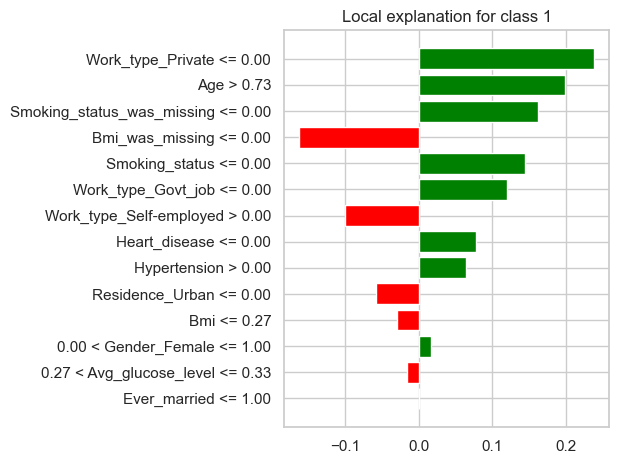

In [28]:
fig = exp.as_pyplot_figure()
fig.tight_layout()

In [29]:
target_idx=1

In [30]:
# Summarize the background data using shap.sample
background_samples = shap.sample(X_train_resampled, 100)  # Adjust the number of samples as needed

# Calculate SHAP values using KernelExplainer
explainer = shap.KernelExplainer(knn.predict_proba, background_samples)
shap_vals = explainer.shap_values(X_train_resampled.iloc[target_idx])

# Visualize the explanation for the specified target index
if len(shap_vals) == 1:
    shap.force_plot(explainer.expected_value[0], shap_vals[0], features=X_train_resampled.iloc[target_idx], feature_names=X_train_resampled.columns)
else:
    print("Error: Unexpected number of SHAP values arrays.")

Error: Unexpected number of SHAP values arrays.


# Permutations

In [31]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(knn, random_state=42).fit(X_validation, y_validation)
eli5.show_weights(perm, feature_names = X_validation.columns.tolist())

Weight,Feature
0.0600 ± 0.0154,Work_type_Private
0.0440 ± 0.0057,Work_type_Govt_job
0.0336 ± 0.0078,Work_type_Self-employed
0.0275 ± 0.0168,Age
0.0016 ± 0.0048,Bmi_was_missing
-0.0002 ± 0.0050,Bmi
-0.0009 ± 0.0040,Heart_disease
-0.0014 ± 0.0281,Residence_Urban
-0.0016 ± 0.0122,Avg_glucose_level
-0.0019 ± 0.0104,Hypertension


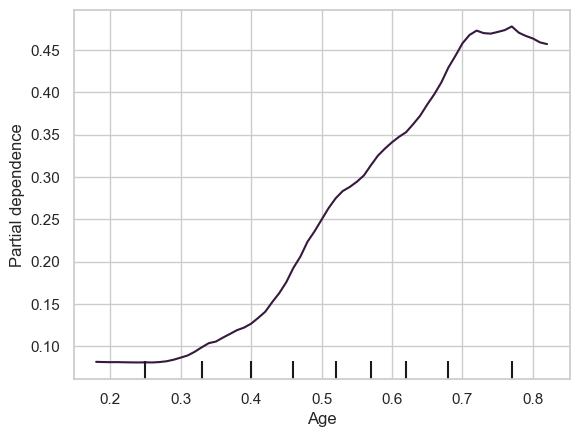

In [32]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(knn, X_validation, ['Age'])
plt.show()

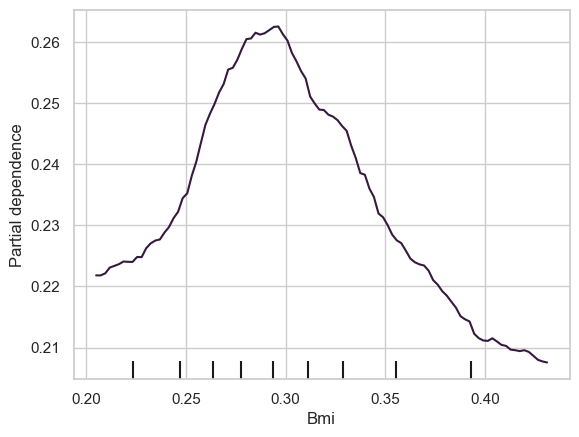

In [33]:
PartialDependenceDisplay.from_estimator(knn, X_validation, ['Bmi'])
plt.show()

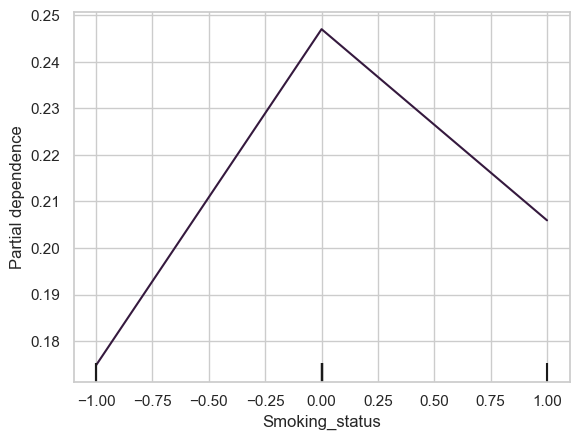

In [34]:
PartialDependenceDisplay.from_estimator(knn, X_validation, ['Smoking_status'])
plt.show()